In [30]:
import os
import sys
import numpy as np
import pandas as pd
import igraph as ig
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_settings_v3 import *
from plot_auxiliary import *
from planar import create_proximity_graph
from auxiliary import get_base_network_name, powerlaw, getLinearReg
from plot_auxiliary import load_dataframe, get_critical_measures

%matplotlib inline

net_type = 'DT'
param = 'param'

net_dir = os.path.join('..', 'networks', net_type)

### Scaling of $N_2$ and $\langle s \rangle$ for different attacks

In [33]:
net_type = 'DT'
measures = ['meanS', 'Nsec']

l_values = [2, 3, 4, 8]
attacks = ['Ran'] + [f'Btw_cutoff{l}' for l in l_values]

sizes = [128, 256, 512, 1024, 2048, 4096, 8192, 16384, 32768]

print('attack\t          beta/nu     beta gamma/nu    gamma        2  delta_2      tau delta_tau     N_max')

data = {}
for k, attack in enumerate(attacks):
    
    data[attack] = {}
    
    dfs = {}
    for N in sizes:
        try:
            dfs[N] = load_dataframe(net_type, N, param, attack, min_nseeds=1000)
        except FileNotFoundError:
            continue
    N_values = np.array(list(dfs.keys()))
    L_values = np.sqrt(N_values)
        
    for i, measure in enumerate(measures):
        
        measure_values = get_critical_measures(dfs, measure, fc='peak')
        Y_pred, slope, y_err = getLinearReg(L_values[-5:], measure_values[-5:])
        
        if measure == 'Nsec':
            beta_over_nu = 2 - slope
            delta_beta = y_err
        elif measure == 'meanS':
            gamma_over_nu = slope
            delta_gamma = y_err       
            
        data[attack][measure] = [L_values, measure_values, Y_pred, slope, y_err]
            
    err_one = 2*delta_beta + delta_gamma
    tau = 2+beta_over_nu/(beta_over_nu+gamma_over_nu)
    delta_tau = np.fabs(delta_beta)/beta_over_nu +\
               (np.fabs(delta_gamma)+np.fabs(delta_beta))*(beta_over_nu/(beta_over_nu + gamma_over_nu))
    
    nu = 4/3
    print(
        '{:10}\t{:9.4f}{:9.4f}{:9.4f}{:9.4f}{:9.4f}{:9.4f}{:9.4f}{:10.4f}{:10.0f}'.format(
        attack, beta_over_nu, beta_over_nu*nu, gamma_over_nu, gamma_over_nu*nu,
        2*beta_over_nu+gamma_over_nu, err_one, tau, delta_tau, np.max(N_values)
        )
    )

attack	          beta/nu     beta gamma/nu    gamma        2  delta_2      tau delta_tau     N_max
Ran       	   0.1073   0.1430   1.6940   2.2587   1.9086   0.0139   2.0595    0.0336     16384
Btw_cutoff2	   0.1628   0.2170   1.6102   2.1469   1.9357   0.0332   2.0918    0.0441     16384
Btw_cutoff3	   0.1780   0.2374   1.5661   2.0882   1.9222   0.0119   2.1021    0.0158     16384
Btw_cutoff4	   0.2444   0.3259   1.4883   1.9844   1.9771   0.0276   2.1411    0.0385      8192
Btw_cutoff8	   0.2525   0.3367   1.5345   2.0460   2.0395   0.1317   2.1413    0.1431      4096


In [34]:
marker_dict = {'meanS': 'o', 'Nsec': 's'}
color_dict = {'meanS': colors[0], 'Nsec': colors[1]}
linestyle_dict = {'meanS': '--', 'Nsec': '-.'}
label_dict = {'meanS': r'$\langle s \rangle$', 'Nsec': r'$S_2 N$'}
line_colors = {'meanS': 'k', 'Nsec': 'grey'}

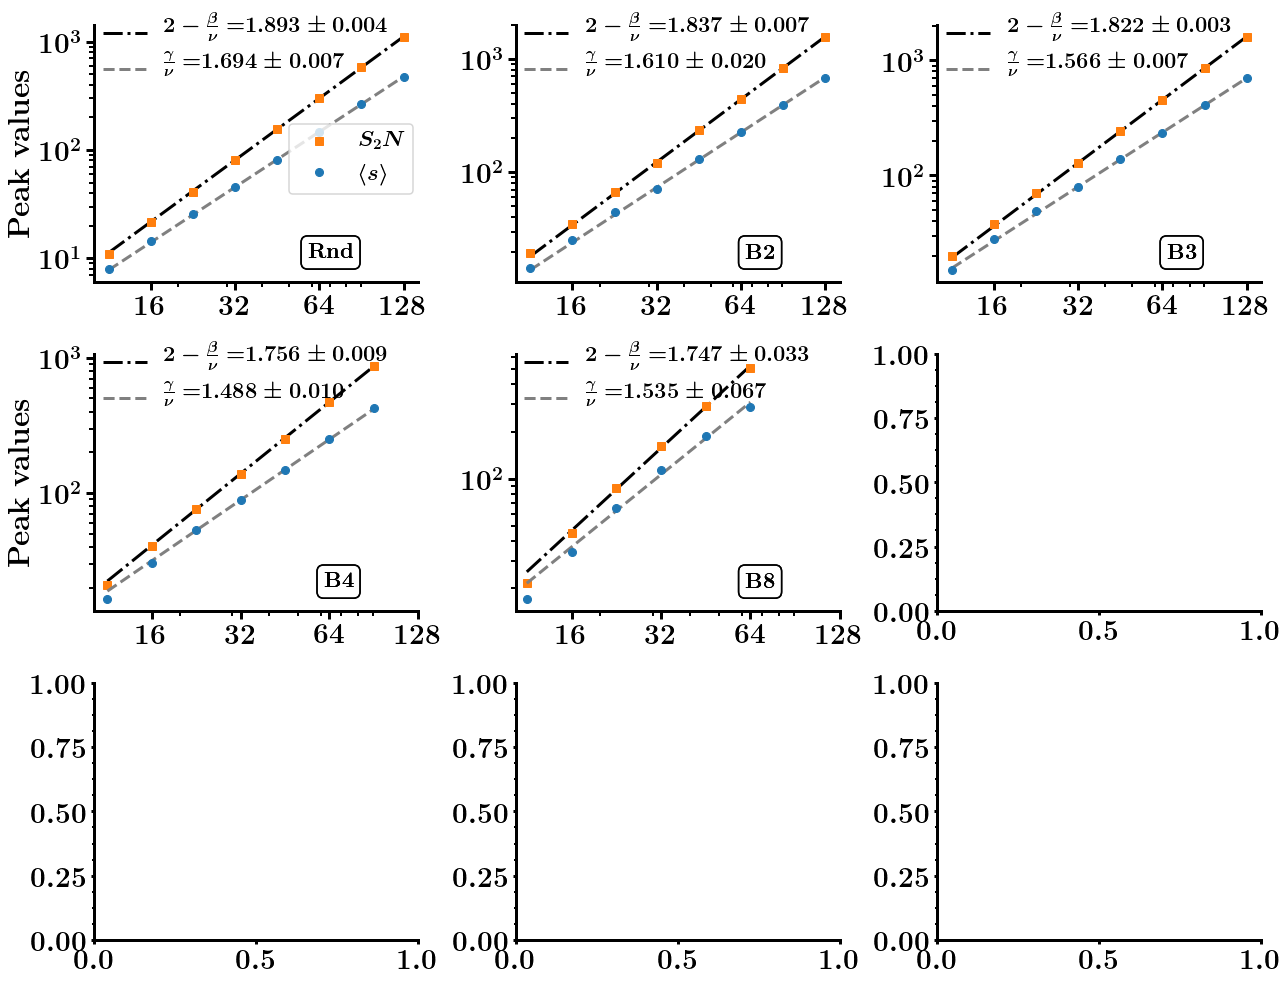

In [35]:
measures = ['Nsec', 'meanS']

ncols = 3
nrows = len(attacks) // ncols + len(attacks) % ncols
fig, axes = plt.subplots(figsize=(6*ncols, 5*nrows), ncols=ncols, nrows=nrows)
axes = axes.flatten()

for k, attack in enumerate(attacks):
    
    ax = axes[k]
    for i, measure in enumerate(measures):
        
        L_values, measure_values, Y_pred, slope, y_err = data[attack][measure]
        
        c = Y_pred[-1]/L_values[-1]**slope
        
        Y_pred = powerlaw(L_values, slope, c)
        
        ax.tick_params(which='minor', length=5)
        ax.tick_params(which='major', length=8)
    
        if k%ncols == 0:
            ax.set_ylabel(r'$\mathrm{Peak\;values}$')
        if k//ncols == nrows - 1:
            ax.set_xlabel(r'$L$')

        if measure == 'meanS':
            label = r'$\frac{\gamma}{\nu} = $' + r'${{{:.3f}}}\pm{{{:.3f}}}$'.format(slope, y_err)
            label1 = label
            line1, = ax.plot(L_values, Y_pred, '--', color='grey', label=label)
            
        elif measure == 'Nsec':
            label = r'$2 - \frac{\beta}{\nu} = $' + r'${{{:.3f}}}\pm{{{:.3f}}}$'.format(slope, y_err)
            label2 = label
            line2, = ax.plot(L_values, Y_pred, '-.', color='k', label=label)            

        ax.set_xscale('log')
        ax.set_yscale('log')
        
        markers1, = ax.plot(
            L_values, measure_values, marker_dict[measure], 
            color=color_dict[measure], markersize=8, 
            label=label_dict[measure] if k == 0 else ''
        )

        bbox = {'boxstyle': 'round', 'fc': 'None'}
        ax.text(0.8, 0.09, attack_dict[attack], fontsize=22, 
                transform=ax.transAxes, horizontalalignment='right', bbox=bbox)
        
    if k == 0:
        handles, labels = ax.get_legend_handles_labels()
        ## Markers
        order = [1, 3]
        legend1 = ax.legend([handles[idx] for idx in order], [labels[idx] for idx in order],
                  fontsize=22, loc=(0.6, 0.34))
        
        ax.add_artist(legend1)
        ## Lines
        order = [0, 2]
        ax.legend([handles[idx] for idx in order], [labels[idx] for idx in order],
                  fontsize=22, loc=(0.0, 0.75), frameon=False)

    else:
        ax.legend(fontsize=22, loc=(0.0, 0.75), frameon=False)

    ax.set_xticks([16, 32, 64, 128])
    ax.get_xaxis().set_minor_formatter(mpl.ticker.NullFormatter())
    ax.get_xaxis().set_major_formatter(mpl.ticker.ScalarFormatter())
        
sns.despine()
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
fig_name = os.path.join(fig_dir, 'peak_scaling_B_' + net_type)
plt.savefig(fig_name + '.png')
plt.savefig(fig_name + '.pdf')
plt.show()

### Scaling of the percolation threshold for RB attack

TypeError: cannot do label indexing on <class 'pandas.core.indexes.numeric.Int64Index'> with these indexers [nan] of <class 'float'>

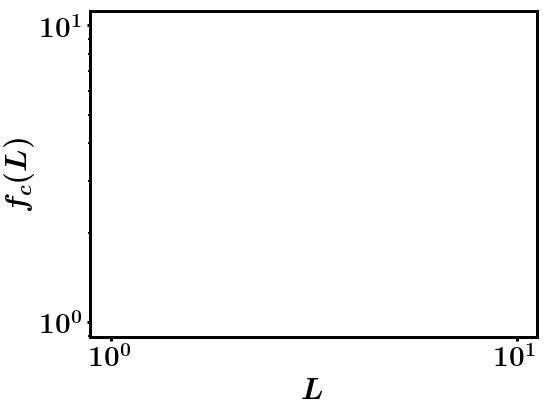

In [12]:
attack = 'BtwU'
measures = ['meanS', 'Nsec']

dfs = {}
for N in sizes:
    try:
        dfs[N] = load_dataframe(net_type, N, param, attack, min_nseeds=1000)
    except FileNotFoundError:
        continue
        
N_values = np.sort(list(dfs.keys()))
L_values = np.sqrt(N_values)
peaks = {}

marker_dict = {'meanS': 'o', 'Nsec': 's'}
color_dict = {'meanS': colors[0], 'Nsec': colors[1]}
linestyle_dict = {'meanS': '--', 'Nsec': '-.'}
label_dict = {'meanS': r'$\langle s \rangle$', 'Nsec': r'$S_2 L^2$'}
ncols = 1
nrows = 1
fig, ax = plt.subplots(figsize=(8*ncols,6*nrows), ncols=ncols, nrows=nrows)
for i, measure in enumerate(measures):
    
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlabel(r'$L$')
    ax.set_ylabel(r'$f_c(L)$')
    X = L_values
    Y, _ = getPeaks(dfs, measure)
    peaks[measure] = Y
    
    Y_pred, slope, y_err = getLinearReg(X, Y)
    
    c = Y[0] / X[0]**slope
    label = r'$1/\nu = $' + r'${{{:.2f}}}\pm{{{:.2f}}}$'.format(slope, y_err)
    ax.plot(X, Y_pred, linestyle_dict[measure], color=line_colors[measure], label=label)
    
    ax.plot(X, Y, marker_dict[measure], markersize=10, label=measures_dict[measure])
    
    ax.set_xlim(12, 128)
    ax.set_xticks([16, 32, 64, 128])
    ax.get_xaxis().set_minor_formatter(mpl.ticker.NullFormatter())
    ax.get_xaxis().set_major_formatter(mpl.ticker.ScalarFormatter())
    
    
handles, labels = ax.get_legend_handles_labels()

## Markers
order = [1, 3]
legend1 = ax.legend([handles[idx] for idx in order], [labels[idx] for idx in order],
          fontsize=22, loc=(0.66, 0.4))

ax.add_artist(legend1)
## Lines
order = [2, 0]
ax.legend([handles[idx] for idx in order], [labels[idx] for idx in order],
          fontsize=22, loc='best', frameon=False)

plt.tight_layout()
fig_name = os.path.join(fig_dir, 'nu_scaling_B_{}'.format(net_type))
plt.savefig(fig_name + '.png')
plt.savefig(fig_name + '.pdf')

plt.show()

In [6]:
print(sizes, peaks)

[256, 512, 1024, 2048, 4096, 8192, 16384] {'meanS': [0.11328125, 0.0859375, 0.068359375, 0.0546875, 0.046630859375, 0.0364990234375], 'Nsec': [0.09375, 0.07421875, 0.05859375, 0.04833984375, 0.038818359375, 0.031982421875]}


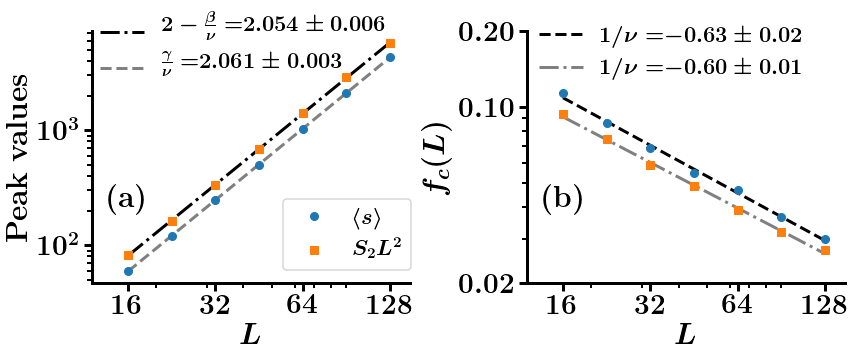

In [31]:
attack = 'BtwU'
measures = ['meanS', 'Nsec']

ncols = 2
nrows = 1
fig, axes = plt.subplots(figsize=(6*ncols, 5*nrows), ncols=ncols, nrows=nrows)

for ax in axes:
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlim(12, 150)
    ax.set_xticks([16, 32, 64, 128])
    ax.get_xaxis().set_minor_formatter(mpl.ticker.NullFormatter())
    ax.get_xaxis().set_major_formatter(mpl.ticker.ScalarFormatter())
    ax.tick_params(which='minor', length=5)
    ax.tick_params(which='major', length=8)
    ax.set_xlabel(r'$L$')
    
ax = axes[0]

ax.text(0.05, 0.3, letters[0], transform=ax.transAxes, fontsize=30)
ax.set_ylabel(r'$\mathrm{Peak\;values}$')

for i, measure in enumerate(measures):

    L_values, measure_values, Y_pred, slope, y_err = data[attack][measure]    

    if measure == 'meanS':
        label = r'$\frac{\gamma}{\nu} = $' + r'${{{:.3f}}}\pm{{{:.3f}}}$'.format(slope, y_err)
        label1 = label
        line1, = ax.plot(L_values, Y_pred, '--', color='grey', label=label)

    elif measure == 'Nsec':
        label = r'$2 - \frac{\beta}{\nu} = $' + r'${{{:.3f}}}\pm{{{:.3f}}}$'.format(slope, y_err)
        label2 = label
        line2, = ax.plot(L_values, Y_pred, '-.', color='k', label=label)            

    markers1, = ax.plot(
        L_values, measure_values, marker_dict[measure], 
        color=color_dict[measure], markersize=8, 
        label=label_dict[measure]
    )

handles, labels = ax.get_legend_handles_labels()
## Markers
order = [1, 3]
legend1 = ax.legend([handles[idx] for idx in order], [labels[idx] for idx in order],
          fontsize=22, loc=(0.6, 0.05))

ax.add_artist(legend1)
## Lines
order = [2, 0]
ax.legend([handles[idx] for idx in order], [labels[idx] for idx in order],
          fontsize=22, loc=(0.0, 0.77), frameon=False)


sizes = [256, 512, 1024, 2048, 4096, 8192, 16384]

dfs = {}
for N in sizes:
    try:
        dfs[N] = load_dataframe(net_type, N, param, attack, min_nseeds=1000)
    except FileNotFoundError:
        continue
        
N_values = np.sort(list(dfs.keys()))
L_values = np.sqrt(N_values)

ax = axes[1]
ax.text(0.05, 0.3, letters[1], transform=ax.transAxes, fontsize=30)
ax.set_ylabel(r'$f_c(L)$')
for i, measure in enumerate(measures):
        
    X = L_values
    Y, _ = getPeaks(dfs, measure)
    
    Y_pred, slope, y_err = getLinearReg(X, Y)
    
    c = Y[0] / X[0]**slope
    label = r'$1/\nu = $' + r'${{{:.2f}}}\pm{{{:.2f}}}$'.format(slope, y_err)
    ax.plot(X, Y_pred, linestyle_dict[measure], color=line_colors[measure], label=label)
    ax.plot(X, Y, marker_dict[measure], markersize=8, label=measures_dict[measure])
    
handles, labels = ax.get_legend_handles_labels()

## Lines
order = [0, 2]
ax.legend([handles[idx] for idx in order], [labels[idx] for idx in order],
          fontsize=22, loc=(0.01, 0.77), frameon=False)

ax.set_ylim(0.02, 0.2)
ax.set_yticks([0.02, 0.1, 0.2])
ax.get_yaxis().set_minor_formatter(mpl.ticker.NullFormatter())
ax.get_yaxis().set_major_formatter(mpl.ticker.ScalarFormatter())
    

sns.despine()
plt.tight_layout()
fig_name = os.path.join(fig_dir, 'beta_gamma_nu_scaling_RB_{}'.format(net_type))
plt.savefig(fig_name + '.png')
plt.savefig(fig_name + '.pdf')

plt.show()

### Gap exponents

In [3]:
attack = 'BtwU'

sizes = np.array([256, 512, 1024, 2048, 4096, 8192, 16384])
all_mean_values = []
all_std_values = []
fluctuations = {}
for i, N in enumerate(sizes):
    delta_values = load_delta(net_type, N, param, attack)
    delta_values[:,2] = delta_values[:,2]*N
    mean_values = delta_values.mean(axis=0)
    std_values = delta_values.std(axis=0)
    
    all_mean_values.append(mean_values)
    all_std_values.append(std_values)
    
    fluctuations[N] = delta_values - mean_values
    
all_mean_values = np.array(all_mean_values)
all_std_values = np.array(all_std_values)


rc_values = all_mean_values[:,0]
delta_values = all_mean_values[:,1]

In [4]:
print(delta_values * sizes)
print(rc_values)

[  98.7374      199.8307      405.705       824.589      1670.95839168
 3405.2484472  6790.6378022 ]
[0.07235313 0.05925488 0.04775498 0.03875347 0.03187801 0.02632624
 0.02202486]


In [5]:
delta_values * sizes * (1-rc_values)

array([  91.59344056,  187.98975529,  386.33056565,  792.63331757,
       1617.69156927, 3315.60104345, 6641.07492281])

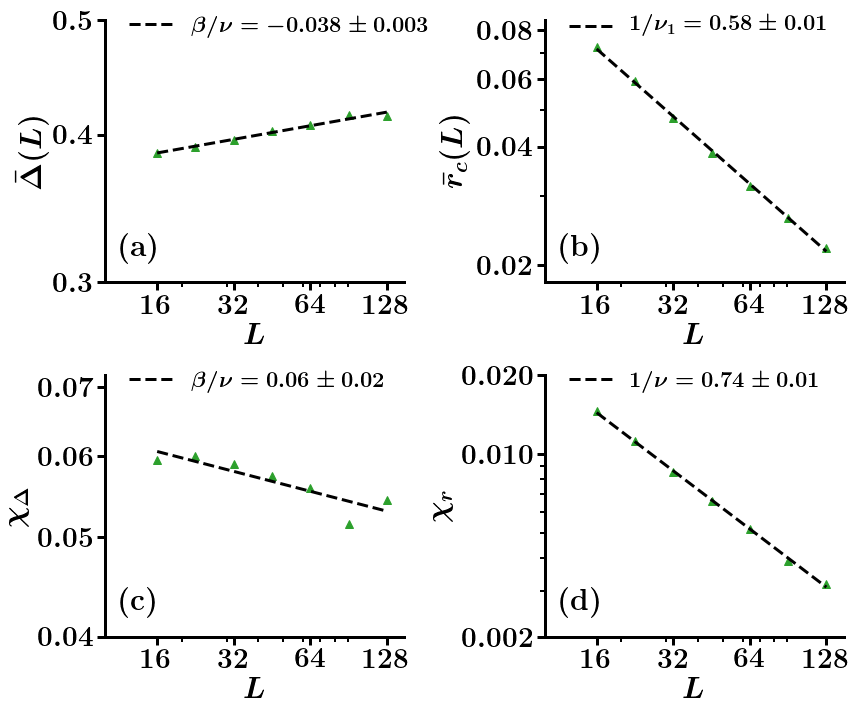

In [16]:
attack = 'BtwU'
measures = ['meanS', 'Nsec']
X = np.sqrt(sizes)

ncols = 2
nrows = 2
fig, axes = plt.subplots(figsize=(6*ncols, 5*nrows), ncols=ncols, nrows=nrows)

for ax in axes.flatten():
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlim(10, 150)
    ax.set_xticks([16, 32, 64, 128])
    ax.get_xaxis().set_minor_formatter(mpl.ticker.NullFormatter())
    ax.get_xaxis().set_major_formatter(mpl.ticker.ScalarFormatter())
    ax.tick_params(which='minor', length=5)
    ax.tick_params(which='major', length=8)
    ax.set_xlabel(r'$L$')
    
ax = axes[0,0]
ax.text(0.05, 0.1, letters[0], transform=ax.transAxes, fontsize=30)
ax.set_ylim([0.3, 0.5])
#ax.set_yticks([0.39, 0.40, 0.41, 0.42])
ax.set_yticks([0.3, 0.40, 0.5])
ax.get_yaxis().set_minor_formatter(mpl.ticker.NullFormatter())
ax.get_yaxis().set_major_formatter(mpl.ticker.ScalarFormatter())
ax.set_ylabel(r'$\bar{\Delta}(L)$')
Y = all_mean_values[:,1]
Y_pred, slope, y_err = getLinearReg(X, Y)
ax.plot(X, Y, '^', color='C2', markersize=8)
ax.plot(X, Y_pred, '--', color='k', label=r'$\beta/\nu={{{:.3f}}}\pm{{{:.3f}}}$'.format(-slope, y_err))
ax.legend(fontsize=22, loc=(0.05, 0.9), frameon=False)

ax = axes[0,1]
ax.text(0.05, 0.1, letters[1], transform=ax.transAxes, fontsize=30)
ax.set_ylim([0.018, 0.085])
ax.set_yticks([0.02, 0.04, 0.06, 0.08])
ax.get_yaxis().set_minor_formatter(mpl.ticker.NullFormatter())
ax.get_yaxis().set_major_formatter(mpl.ticker.ScalarFormatter())

ax.set_ylabel(r'$\bar{r}_c(L)$')
Y = all_mean_values[:,0]
Y_pred, slope, y_err = getLinearReg(X, Y)
ax.plot(X, Y, '^', color='C2', markersize=8)
ax.plot(X, Y_pred, '--', color='k', label=r'$1/\nu_1={{{:.2f}}}\pm{{{:.2f}}}$'.format(-slope, y_err))
ax.legend(fontsize=22, loc=(0.05, 0.9), frameon=False)

ax = axes[1,0]
ax.text(0.05, 0.1, letters[2], transform=ax.transAxes, fontsize=30)
ax.set_ylim([0.04, 0.072])
ax.set_yticks([0.04, 0.05, 0.06, 0.07])
ax.get_yaxis().set_minor_formatter(mpl.ticker.NullFormatter())
ax.get_yaxis().set_major_formatter(mpl.ticker.ScalarFormatter())
ax.set_ylabel(r'$\chi_{\Delta}$')
Y = all_std_values[:,1]
Y_pred, slope, y_err = getLinearReg(X, Y)
beta_over_nu = -slope
ax.plot(X, Y, '^', color='C2', markersize=8)
ax.plot(X, Y_pred, '--', color='k', label=r'$\beta/\nu={{{:.2f}}}\pm{{{:.2f}}}$'.format(-slope, y_err))
ax.legend(fontsize=22, loc=(0.05, 0.9), frameon=False)


ax = axes[1,1]
ax.text(0.05, 0.1, letters[3], transform=ax.transAxes, fontsize=30)
ax.set_ylim([0.002, 0.02])
ax.set_yticks([0.002, 0.01, 0.02])
ax.get_yaxis().set_minor_formatter(mpl.ticker.NullFormatter())
ax.get_yaxis().set_major_formatter(mpl.ticker.ScalarFormatter())
ax.set_ylabel(r'$\chi_{r}$')
Y = all_std_values[:,0]
Y_pred, slope, y_err = getLinearReg(X, Y)
ax.plot(X, Y, '^', color='C2', markersize=8)
ax.plot(X, Y_pred, '--', color='k', label=r'$1/\nu={{{:.2f}}}\pm{{{:.2f}}}$'.format(-slope, y_err))
ax.legend(fontsize=22, loc=(0.05, 0.9), frameon=False)

sns.despine()
plt.tight_layout()
fig_name = os.path.join(fig_dir, 'gap_exp_scaling_RB_{}'.format(net_type))
plt.savefig(fig_name + '.png')
plt.savefig(fig_name + '.pdf')

plt.show()

## $r_c$ and $f_c$ vs $L$

NameError: name 'line_colors' is not defined

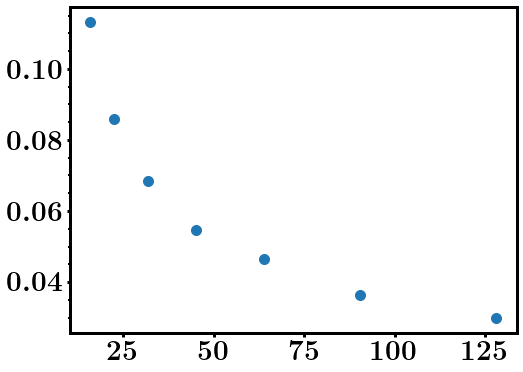

In [7]:
attack = 'BtwU'
measures = ['meanS', 'Nsec']

sizes = np.array([256, 512, 1024, 2048, 4096, 8192, 16384])
rc_values = np.zeros_like(sizes)

for i, N in enumerate(sizes):
    delta_values = load_delta(net_type, N, param, attack)
    rc_values[i] = delta_values[:,0].mean()

dfs = {}
for N in sizes:
    try:
        dfs[N] = load_dataframe(net_type, N, param, attack, min_nseeds=1000)
    except FileNotFoundError:
        continue
        
N_values = np.sort(list(dfs.keys()))
L_values = np.sqrt(N_values)

marker_dict = {'meanS': 'o', 'Nsec': 's'}
color_dict = {'meanS': colors[0], 'Nsec': colors[1]}
linestyle_dict = {'meanS': '--', 'Nsec': '-.'}
label_dict = {'meanS': r'$\langle s \rangle$', 'Nsec': r'$S_2 L^2$'}
ncols = 1
nrows = 1
fig, ax = plt.subplots(figsize=(8*ncols,6*nrows), ncols=ncols, nrows=nrows)

for i, measure in enumerate(measures):
    
    X = L_values
    fc_values, _ = getPeaks(dfs, measure)
    Y = fc_values - rc_values
    Y_pred, slope, y_err = getLinearReg(X, Y)
    
    c = Y[0] / X[0]**slope

    ax.plot(X, Y, marker_dict[measure], markersize=10, label=measures_dict[measure])
    
    label = r'$\zeta = $' + r'${{{:.2f}}}\pm{{{:.2f}}}$'.format(slope, y_err)
    ax.plot(X, Y_pred, linestyle_dict[measure], color=line_colors[measure], label=label)
    
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlabel(r'$L$')
    ax.set_ylabel(r'$f_c(L) - r_c(L)$')
    ax.set_xlim(12, 150)
    ax.set_xticks([16, 32, 64, 128])
    ax.get_xaxis().set_minor_formatter(mpl.ticker.NullFormatter())
    ax.get_xaxis().set_major_formatter(mpl.ticker.ScalarFormatter())

handles, labels = ax.get_legend_handles_labels()
    
## Lines
order = [1, 3]
legend1 = ax.legend([handles[idx] for idx in order], [labels[idx] for idx in order],
          fontsize=22, loc='lower left', frameon=False)

ax.add_artist(legend1)
## Merkers
order = [0, 2]
ax.legend([handles[idx] for idx in order], [labels[idx] for idx in order],
          fontsize=22, loc='best', frameon=False)

sns.despine()
plt.tight_layout()
fig_name = os.path.join(fig_dir, 'rc_and_fc_vs_L{}'.format(net_type))
plt.savefig(fig_name + '.png')
plt.savefig(fig_name + '.pdf')

plt.show()

### Curves collapsing

1024
2048
4096
8192
16384


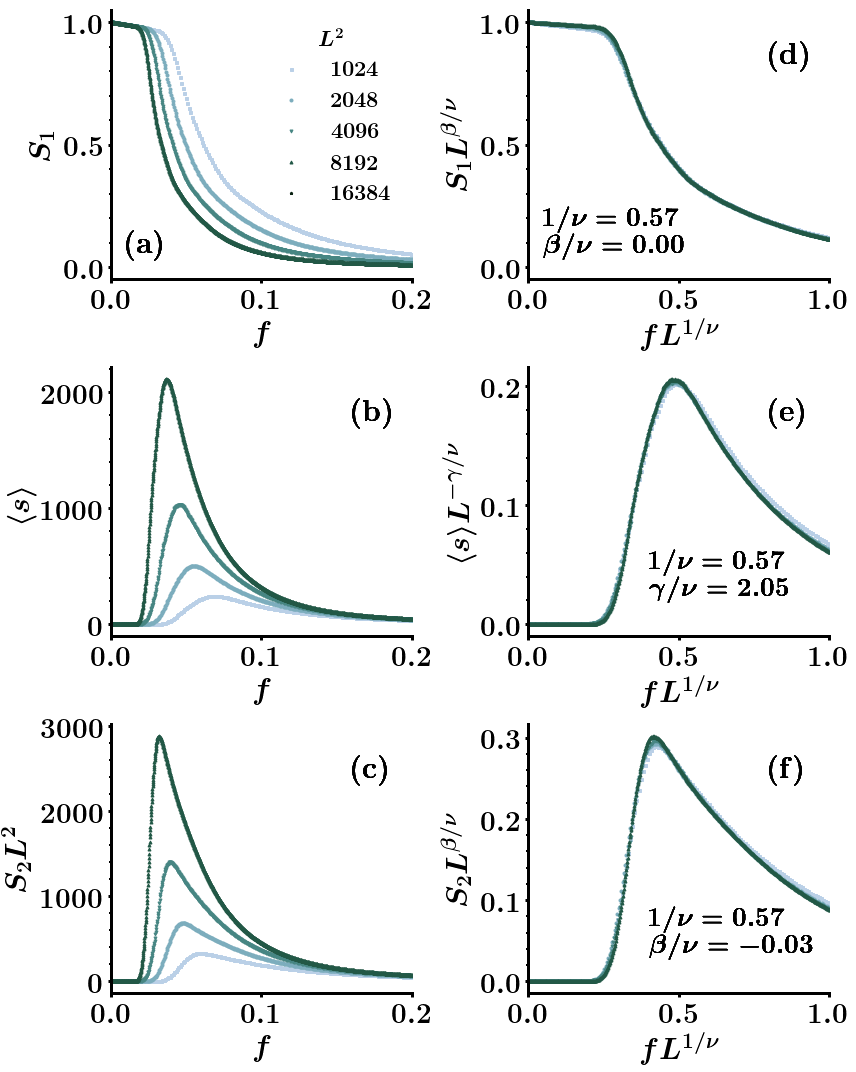

In [3]:
attack = 'BtwU'
sizes = [1024, 2048, 4096, 8192, 16384]

dfs = {}
for N in sizes:
    try:
        dfs[N] = load_dataframe(net_type, N, param, attack, min_nseeds=100)
    except FileNotFoundError:
        continue
        
N_values = np.sort(list(dfs.keys()))
L_values = np.sqrt(N_values)

colormap = sns.cubehelix_palette(
    len(L_values), start=2, rot=0.3, light=0.8, dark=0.1
)

ncols = 2
nrows = 3
fig, axes = plt.subplots(figsize=(6*ncols, 5*nrows), ncols=ncols, nrows=nrows)
    
for ax in axes[:,0]:
    ax.set_xlim(0, 0.2)
    ax.set_xlabel(r'$f$')
for ax in axes[:,1]:
    ax.set_xlim(0, 1)
    ax.set_xlabel(r'$f L^{1/\nu}$')
    
ax = axes[0,0]
ax.set_ylabel(r'$S_1$')
ax = axes[1,0]
ax.set_ylabel(r'$\langle s\rangle$')
ax = axes[2,0]
ax.set_ylabel(r'$S_2L^2$')

ax = axes[0,1]
#ax.set_ylim(0.1, 1.05)
ax.set_ylabel(r'$S_1 L^{\beta/\nu}$')
ax = axes[1,1]
ax.set_ylabel(r'$\langle s\rangle L^{-\gamma/\nu}$')
ax = axes[2,1]
ax.set_ylabel(r'$S_2 L^{\beta/\nu}$')

for i, N in enumerate(N_values):
    print(N)
    df = dfs[N]
    L = np.sqrt(N)

    ax = axes[0,0]
    ax.text(0.05, 0.1, letters[0], transform=ax.transAxes, fontsize=30)
    ax.plot(df.f, df.Sgcc, linestyle='', marker=markers[i], markersize=3,
            label=r'${{{}}}$'.format(N), color=colormap[i])
    
    ax = axes[0,1]
    ax.text(0.8, 0.8, letters[3], transform=ax.transAxes, fontsize=30)
    #one_over_nu = 5/9
    one_over_nu = 0.57
    nu = 1 / one_over_nu
    beta = 0
    beta_over_nu = beta / nu
    ax.plot(df.f*L**one_over_nu, df.Sgcc*N**(beta_over_nu), linestyle='', marker=markers[i], markersize=3,
        label=r'${{{}}}$'.format(N), color=colormap[i])
    #ax.text(0.05, 0.4, r'$\nu = {{{:.2f}}}$'.format(nu), 
    #        transform=ax.transAxes, fontsize=26)
    ax.text(0.05, 0.2, r'$1/\nu = {{{:.2f}}}$'.format(one_over_nu), 
            transform=ax.transAxes, fontsize=26)
    #ax.text(0.05, 0.2, r'$\beta = {{{:.2f}}}$'.format(beta), 
    #        transform=ax.transAxes, fontsize=26)
    ax.text(0.05, 0.1, r'$\beta/\nu = {{{:.2f}}}$'.format(beta_over_nu), 
            transform=ax.transAxes, fontsize=26)
    
    
    ax = axes[1,0]
    ax.text(0.8, 0.8, letters[1], transform=ax.transAxes, fontsize=30)
    ax.plot(
        df.f, df.meanS, linestyle='', marker=markers[i], markersize=3, color=colormap[i]
    )
    ax = axes[1,1]
    ax.text(0.8, 0.8, letters[4], transform=ax.transAxes, fontsize=30)
    #one_over_nu = 5/9
    one_over_nu = 0.57
    nu = 1 / one_over_nu
    gamma_over_nu = 2.05
    gamma = gamma_over_nu * nu
    ax.plot(
        df.f*L**one_over_nu, df.meanS*L**(-gamma_over_nu), linestyle='', 
        marker=markers[i], markersize=3, color=colormap[i]
    )
    ax.text(0.4, 0.25, r'$1/\nu = {{{:.2f}}}$'.format(one_over_nu), 
        transform=ax.transAxes, fontsize=26)
    #ax.text(0.4, 0.35, r'$\nu = {{{:.2f}}}$'.format(nu), 
    #        transform=ax.transAxes, fontsize=26)
    #ax.text(0.4, 0.25, r'$\gamma = {{{:.2f}}}$'.format(gamma), 
    #        transform=ax.transAxes, fontsize=26)
    ax.text(0.4, 0.15, r'$\gamma/\nu = {{{:.2f}}}$'.format(gamma_over_nu), 
            transform=ax.transAxes, fontsize=26)
    
    
    ax = axes[2,0]
    ax.text(0.8, 0.8, letters[2], transform=ax.transAxes, fontsize=30)
    ax.plot(
        df.f, df.Nsec, linestyle='', marker=markers[i], markersize=3, color=colormap[i]
    )
    ax = axes[2,1]
    ax.text(0.8, 0.8, letters[5], transform=ax.transAxes, fontsize=30)
    #one_over_nu = 5/9
    one_over_nu = 0.57
    nu = 1 / one_over_nu
    beta = -0.06
    beta_over_nu = beta / nu
    ax.plot(
        df.f*L**one_over_nu, df.Nsec*L**(beta_over_nu-2), linestyle='', 
        marker=markers[i], markersize=3, color=colormap[i]
    )
    ax.text(0.4, 0.25, r'$1/\nu = {{{:.2f}}}$'.format(one_over_nu), 
        transform=ax.transAxes, fontsize=26)
    #ax.text(0.4, 0.35, r'$\nu = {{{:.2f}}}$'.format(nu), 
    #        transform=ax.transAxes, fontsize=26)
    #ax.text(0.4, 0.25, r'$\beta = {{{:.2f}}}$'.format(beta), 
    #        transform=ax.transAxes, fontsize=26)
    ax.text(0.4, 0.15, r'$\beta/\nu = {{{:.2f}}}$'.format(beta_over_nu), 
            transform=ax.transAxes, fontsize=26)


legend = axes[0,0].legend(fontsize=22, frameon=False)
legend.set_title(r'$L^2$', prop={'size':22})

sns.despine()
plt.tight_layout()
fig_name = os.path.join(fig_dir, 'collapse_RB_{}'.format(net_type))
plt.savefig(fig_name + '.png')
plt.savefig(fig_name + '.pdf')
plt.show()

1024
2048
4096
8192
16384


/media/nahuel/datos/d/anaconda3/envs/networks3/lib/python3.7/site-packages/matplotlib/figure.py:2369: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


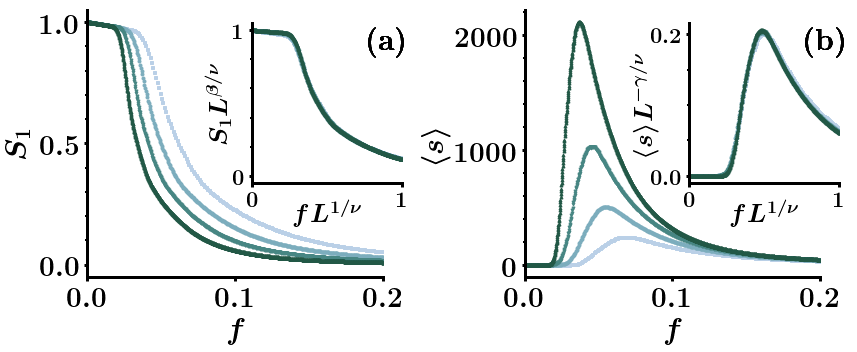

In [33]:
attack = 'BtwU'
sizes = [1024, 2048, 4096, 8192, 16384]

dfs = {}
for N in sizes:
    try:
        dfs[N] = load_dataframe(net_type, N, param, attack, min_nseeds=100)
    except FileNotFoundError:
        continue
        
N_values = np.sort(list(dfs.keys()))
L_values = np.sqrt(N_values)

colormap = sns.cubehelix_palette(
    len(L_values), start=2, rot=0.3, light=0.8, dark=0.1
)

insets = []

ncols = 2
nrows = 1
fig, axes = plt.subplots(figsize=(6*ncols, 5*nrows), ncols=ncols, nrows=nrows)
    
for ax in axes:
    ax.set_xlim(0, 0.2)
    
ax = axes[0]
ax.set_xlabel(r'$f$')
ax.set_ylabel(r'$S_1$')


bbox_to_anchor = (.6, .4, .51, .6)
axins = inset_axes(ax, width="100%", height="100%",
        bbox_to_anchor=bbox_to_anchor,
        bbox_transform=ax.transAxes)
insets.append(axins)
axins.patch.set_alpha(0.)
axins.set_xlim(0, 1)
axins.set_xticks([0, 1])
axins.set_yticks([0, 1])
axins.set_ylabel(r'$S_1 L^{\beta/\nu}$', fontsize=26)
axins.set_xlabel(r'$f L^{1/\nu}$', fontsize=26)
axins.xaxis.set_label_coords(0.5, -0.1)
axins.yaxis.set_label_coords(-0.1, 0.5)
axins.tick_params(axis='both', which='major', labelsize=22)

#######################################

ax = axes[1]
ax.set_xlabel(r'$f$')
ax.set_ylabel(r'$\langle s\rangle$')


bbox_to_anchor = (.6, .4, .51, .6)
axins = inset_axes(ax, width="100%", height="100%",
        bbox_to_anchor=bbox_to_anchor,
        bbox_transform=ax.transAxes)
insets.append(axins)
axins.patch.set_alpha(0.)
axins.set_xlim(0, 1)
axins.set_xticks([0, 1])
axins.set_yticks([0, 0.2])
axins.set_ylabel(r'$\langle s\rangle L^{-\gamma/\nu}$', fontsize=26)
axins.set_xlabel(r'$f L^{1/\nu}$', fontsize=26)
axins.xaxis.set_label_coords(0.5, -0.1)
axins.yaxis.set_label_coords(-0.2, 0.5)
axins.tick_params(axis='both', which='major', labelsize=22)


for i, N in enumerate(N_values):
    print(N)
    df = dfs[N]
    L = np.sqrt(N)

    ax = axes[0]
    ax.text(0.95, 0.85, letters[0], transform=ax.transAxes, fontsize=30)
    ax.plot(df.f, df.Sgcc, linestyle='', marker=markers[i], markersize=3,
            label=r'${{{}}}$'.format(N), color=colormap[i])
    
    ax = insets[0]
    one_over_nu = 0.57
    nu = 1 / one_over_nu
    beta = 0
    beta_over_nu = beta / nu
    ax.plot(df.f*L**one_over_nu, df.Sgcc*N**(beta_over_nu), linestyle='', marker=markers[i], markersize=3,
        label=r'${{{}}}$'.format(N), color=colormap[i])
    
    
    ax = axes[1]
    ax.text(0.95, 0.85, letters[1], transform=ax.transAxes, fontsize=30)
    ax.plot(
        df.f, df.meanS, linestyle='', marker=markers[i], markersize=3, color=colormap[i]
    )
    ax = insets[1]
    one_over_nu = 0.57
    nu = 1 / one_over_nu
    gamma_over_nu = 2.05
    gamma = gamma_over_nu * nu
    ax.plot(
        df.f*L**one_over_nu, df.meanS*L**(-gamma_over_nu), linestyle='', 
        marker=markers[i], markersize=3, color=colormap[i]
    )

#legend = axes[0].legend(fontsize=22, frameon=False)
#legend.set_title(r'$L^2$', prop={'size':22})

sns.despine()
plt.tight_layout()
fig_name = os.path.join(fig_dir, 'PRL_collapse_RB_{}'.format(net_type))
plt.savefig(fig_name + '.png')
plt.savefig(fig_name + '.pdf')
plt.show()

In [10]:
l_values = list(range(2, 17)) + [54]
attacks = ['BtwU'] + [ f'BtwU_cutoff{l}' for l in l_values]

N = 16384
for k, attack in enumerate(attacks):   
    
    try:
        df = load_dataframe(net_type, N, param, attack, min_nseeds=1000)
    except FileNotFoundError:
        continue
    dfs = {N: df}
    
    try:
        delta_values = load_delta(net_type, N, param, attack)
        rc = delta_values[:,0].mean()
    except:
        rc = np.NaN
        
    fc_meanS = getPeaks(dfs, 'meanS')[0][0]
    fc_Nsec = getPeaks(dfs, 'Nsec')[0][0]
    
        
    dfs = {N: df}    
        
    #print(f'"{attack}:, ["{rc:5.5f}", "{fc_meanS:.5f}", "{fc_Nsec:.5f}"],')
    print(f'"{attack}": ["{rc:.5f}", "{fc_meanS:.5f}", "{fc_Nsec:.5f}"],')

"BtwU": ["0.02202", "0.02985", "0.02692"],
